In [1]:
import os
%load_ext autoreload
%autoreload 2

""""
"""

'"\n'

# Load a dataset


To load and plot a dataset of neural activity across population, in a PopAnal class object.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from neuralmonkey.classes.population_mult import load_handsaved_wrapper
DFallpa = load_handsaved_wrapper()

In [ ]:
# First noirmalize before combine

##### [Optionally, merge across events]

In [7]:

from neuralmonkey.classes.population_mult import dfpa_group_and_split

DFallpa = dfpa_group_and_split(DFallpa, ["event"], concat_dim="trials")


In [8]:

DFallpa
pa = DFallpa["pa"].values[0]
pa.Xlabels["trials"]["event"].value_counts()


event
trial|03_samp|(-0.8, 0.8)              424
trial|05_first_raise|(-0.8, 0.8)       424
trial|06_on_strokeidx_0|(-0.8, 0.8)    424
Name: count, dtype: int64

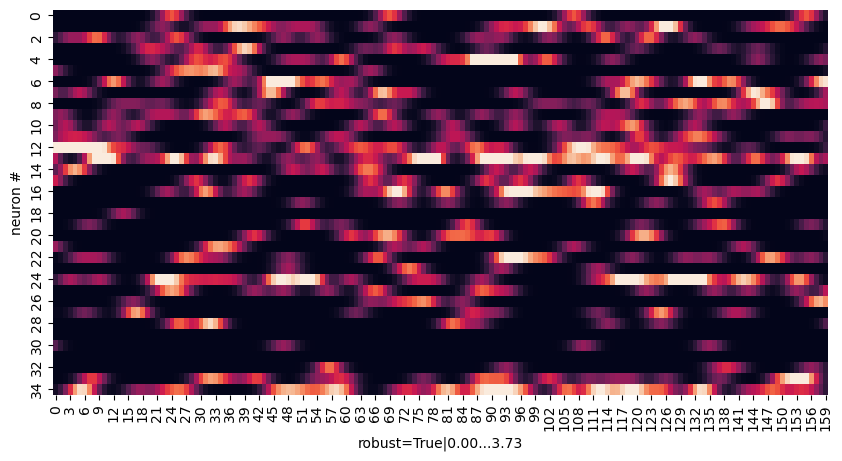

In [9]:

pa.plotNeurHeat(0)

In [10]:
pa.slice_by_dim_values_wrapper("times", [0, 0.4])

##### Preprocess fr normalization?

In [5]:
from neuralmonkey.classes.population_mult import dfallpa_preprocess_fr_normalization
dfallpa_preprocess_fr_normalization(DFallpa, "across_time_bins")

In [6]:
import numpy as np

# Normalize to Fr range from (0,1)
for pa in DFallpa["pa"].values:
    if False:
        mins = np.min(np.min(pa.X, axis=1, keepdims=True), axis=2, keepdims=True)
        maxs = np.max(np.max(pa.X, axis=1, keepdims=True), axis=2, keepdims=True)
        pa.X = (pa.X - mins)/(maxs-mins)
    else:
        MAX = 2*np.max(np.std(pa.X.reshape((pa.X.shape[0], pa.X.shape[1] * pa.X.shape[2])), axis=1))
        mins = np.min(np.min(pa.X, axis=1, keepdims=True), axis=2, keepdims=True)
        pa.X = (pa.X - mins)/(MAX)        
        # pa.X = pa.X/pa.X.std() # to put in range



##### Inspect DFallpa

In [ ]:
DFallpa

In [ ]:
pa = DFallpa["pa"].values[0]
pa.Xlabels["trials"]["seqc_0_loc"][:2]

In [ ]:
[col for col in pa.Xlabels["trials"].columns if "seqc" in col]

# SliceTCA

In [11]:
from slicetca.plotting import grid

import slicetca
import torch
from matplotlib import pyplot as plt

device = ('cuda' if torch.cuda.is_available() else 'cpu')



In [12]:
DFallpa

,which_level,bregion,twind,event,pa,pa_x_shape
0,trial,FP,"(-0.8, 0.8)",dummy,<neuralmonkey.classes.population.PopAnal objec...,"(35, 1272, 160)"
1,trial,M1,"(-0.8, 0.8)",dummy,<neuralmonkey.classes.population.PopAnal objec...,"(43, 1272, 160)"
2,trial,PMd,"(-0.8, 0.8)",dummy,<neuralmonkey.classes.population.PopAnal objec...,"(37, 1272, 160)"
3,trial,PMv,"(-0.8, 0.8)",dummy,<neuralmonkey.classes.population.PopAnal objec...,"(69, 1272, 160)"
4,trial,SMA,"(-0.8, 0.8)",dummy,<neuralmonkey.classes.population.PopAnal objec...,"(53, 1272, 160)"
5,trial,dlPFC,"(-0.8, 0.8)",dummy,<neuralmonkey.classes.population.PopAnal objec...,"(23, 1272, 160)"
6,trial,preSMA,"(-0.8, 0.8)",dummy,<neuralmonkey.classes.population.PopAnal objec...,"(67, 1272, 160)"
7,trial,vlPFC,"(-0.8, 0.8)",dummy,<neuralmonkey.classes.population.PopAnal objec...,"(54, 1272, 160)"


In [15]:
pa = DFallpa["pa"].values[3]

pa.slice_by_dim_values_wrapper("times", [-0.1, 0.4])

In [16]:
import numpy as np
your_data = np.transpose(pa.X, (1, 0, 2))

# your_data is a numpy array of shape (trials, neurons, time).
data = torch.tensor(your_data, device=device, dtype=torch.float32)

# Rescale all
data = data/data.std()

# number_components = (5,0,0)
number_components = (7,0,0)
# The tensor is decomposed into 2 trial-, 0 neuron- and 3 time-slicing components.
components, model = slicetca.decompose(data,
                                       number_components=number_components,
                                       positive=True,
                                       learning_rate=5*10**-3,
                                       min_std=10**-5,
                                       max_iter=10000,
                                       seed=0)

# For a not positive decomposition, we apply uniqueness constraints
# model = slicetca.invariance(model)


  0%|          | 0/10000 [00:00<?, ?it/s]

The model converged. Loss: 0.5591405630111694 :  34%|███▍      | 3421/10000 [01:26<02:46, 39.56it/s]


NameError: name 'savedir' is not defined

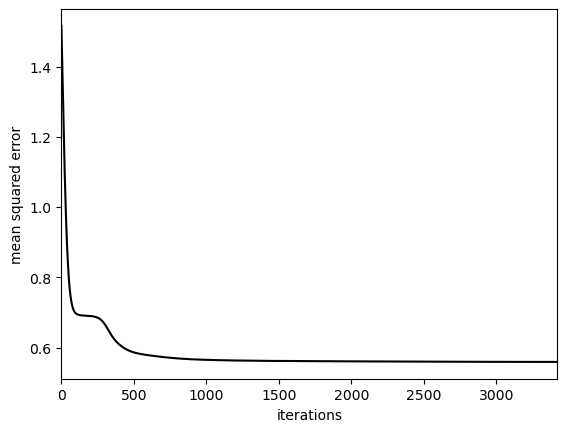

In [17]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(model.losses)), model.losses, 'k')
ax.set_xlabel('iterations')
ax.set_ylabel('mean squared error')
ax.set_xlim(0,len(model.losses))

path = f"{savedir}/losses.pdf"
savefig(fig, path)

### Plot

In [18]:
savedir = "/tmp/FIGS"
os.makedirs(savedir, exist_ok=True)
from pythonlib.tools.plottools import savefig

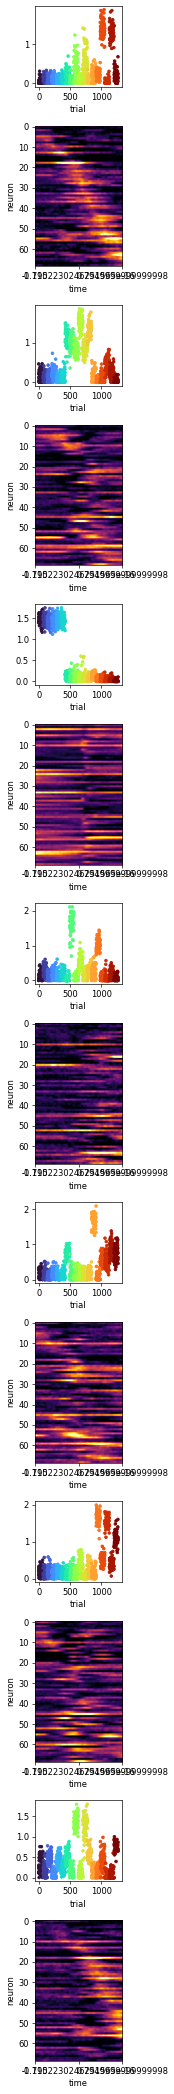

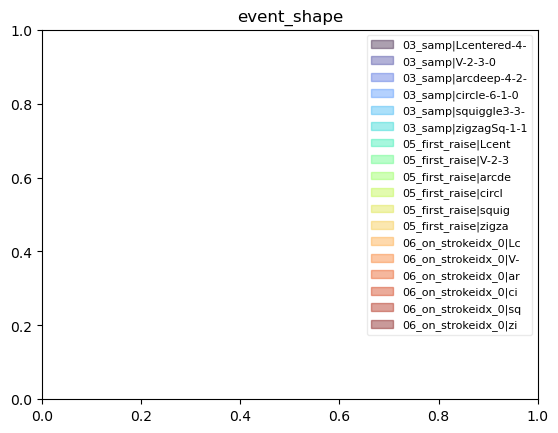

In [19]:

# a new variable, conjunction
from pythonlib.tools.pandastools import append_col_with_grp_index

dflab = pa.Xlabels["trials"]
if True: # concat events, so need each shape and event
    dflab = append_col_with_grp_index(dflab, ["event_orig", "seqc_0_shape"], "event_shape")
    list_var_color = ["event_shape"]
else:
    list_var_color = ["seqc_0_shape", "seqc_0_loc"]


for var_color in list_var_color:
    times = pa.Times
    labels = dflab[var_color]
    from neuralmonkey.analyses.state_space_good import _trajgood_make_colors_discrete_var
    _map_lev_to_color, color_type, colors = _trajgood_make_colors_discrete_var(labels)
    colors_arr = np.stack(colors)

    # sort by trials
    trial_idx = np.argsort(labels).tolist()
    # we sort the neurons of the trial slices according to their peak activity in the first slice.
    neuron_sorting_peak_time = np.argsort(np.argmax(components[0][1][0], axis=1))

    # call plotting function, indicating index for sorting trials and colors for different angles as well as time

    fig, axes = slicetca.plot(model,
                variables=('trial', 'neuron', 'time'),
                colors=(colors_arr[trial_idx], None, None), # we only want the trials to be colored
                ticks=(None, None, np.linspace(0, len(times),3)), # we only want to modify the time ticks
                tick_labels=(None, None, np.linspace(times[0],times[-1],3)),
                sorting_indices=(trial_idx, neuron_sorting_peak_time, None),
                quantile=0.99, return_fig=True)

    path = f"{savedir}/colorby={var_color}.pdf"
    savefig(fig, path)

    from pythonlib.tools.plottools import legend_add_manual
    # - legend for the color
    fig, ax = plt.subplots()
    legend_add_manual(ax, _map_lev_to_color.keys(), _map_lev_to_color.values())
    ax.set_title(var_color)
    savefig(fig, f"{savedir}/legend_colorby={var_color}.pdf")


### Reconstruct data

In [ ]:
reconstruction_full = model.construct().numpy(force=True)
print(reconstruction_full.shape)


In [ ]:
pa.X.shape

In [ ]:
# Try plotting using pa
pa_sTCA = pa.copy()
pa_sTCA.X = reconstruction_full.transpose((1,0,2))

In [ ]:
idx = 100
pa.plotNeurHeat(idx)
pa_sTCA.plotNeurHeat(idx)

### Try running decoder on pa

In [ ]:
DFallpaTHIS = DFallpa.copy()

In [ ]:
DFallpaThis = pd.DataFrame(
    {"which_level":"trial", "event":"06_on_strokeidx_0", "bregion":"PMv", "twind":(-0.8, 0.8), "pa":pa_sTCA})
DFallpaThis

In [ ]:
df = pd.DataFrame(DFallpa.loc[17,:])
df

In [ ]:
SAVEDIR_ANALYSIS = "/tmp"

In [ ]:
from neuralmonkey.analyses.decode_good import decodewrapouterloop_categorical_timeresolved_within_condition

SAVEDIR = f"{SAVEDIR_ANALYSIS}/3_within_condition_decoding"
os.makedirs(SAVEDIR, exist_ok=True)
print(SAVEDIR)

# PARAMS

separate_by_task_kind = True

# Context
# Context
list_var_decode = [
    "seqc_0_shape",
]
list_vars_conj = [
    ["seqc_0_loc", "task_kind"], # minimal control
    ]
filtdict = None
# filtdict = {
#     "stroke_index":[0,3,4,5,6,7,8],
# }

# RUns
max_nsplits = 2
time_bin_size = 0.2
slide = 0.2

# PARAMS
DFRES = decodewrapouterloop_categorical_timeresolved_within_condition(DFallpa, list_var_decode,
                                                     list_vars_conj,
                                                    SAVEDIR, time_bin_size=time_bin_size, slide=slide, filtdict=filtdict,
                                                                      separate_by_task_kind=separate_by_task_kind)


### Cross validation - identify n components

In [ ]:
train_mask, test_mask = slicetca.block_mask(dimensions=data.shape,
                                            train_blocks_dimensions=(1, 1, 10), # Note that the blocks will be of size 2*train_blocks_dimensions + 1
                                            test_blocks_dimensions=(1, 1, 5), # Same, 2*test_blocks_dimensions + 1
                                            fraction_test=0.1,
                                            device=device)
# we define the tensor
min_ranks = [2, 0, 0]


# this will take a while to run as it fits 3*3*3*4 = 108 models
loss_grid, seed_grid = slicetca.grid_search(data,
                                            min_ranks = min_ranks,
                                            max_ranks = [5, 2, 2],
                                            sample_size=4,
                                            mask_train=train_mask,
                                            mask_test=test_mask,
                                            processes_grid=4,
                                            seed=1,
                                            min_std=10**-4,
                                            learning_rate=5*10**-3,
                                            max_iter=10**4,
                                            positive=True)
reduction = "mean"
fig = slicetca.plot_grid(loss_grid, min_ranks=min_ranks, reduction=reduction, return_fig=True)
path = f"{SAVEDIR}/grid_search.pdf"
savefig(fig, path)
# Determine how many components to use
reduction = "mean"
if reduction == "mean":
    reduced_loss_grid = loss_grid.mean(axis=-1)
elif reduction == "min":
    reduced_loss_grid = loss_grid.min(axis=-1)
else:
    raise Exception('Reduction should be mean or min.')

min_index = np.unravel_index(np.argmin(reduced_loss_grid), reduced_loss_grid.shape)
print(min_index)

number_components = tuple([a + b for a, b in zip(min_ranks, min_index)])

